# BECP: Regression modelling
### *by Jose Correa*

__________________

<a id='data-intro'></a>

# Introduction

In this notebook, we utilize insights acquired from prior analyses to enhance the Building Energy Consumption Predictor (BECP). Progressing toward more sophisticated models like ensemble learning and multivariate approaches, our aim is to achieve improved MAE performance. In the previous '03_modelling_timeseries' notebook, we executed various time series analysis models, encompassing the baseline mean, auto-regressive, and AutoRegressive Integrated Moving Average (ARIMA), concluding that the latter emerged as the best-performing model.

**Analysis steps**

We'll employ Python within the Jupyter notebook, operating in an 'Ensemble' environment, and utilize libraries such as pandas for data management, matplotlib for visualization, and sklearn, xgboost, random forest regressor, and SARIMAX for machine learning. Finally, we'll incorporate permutation_importance and shap for enhancing interpretability. The outlined steps are as follows.
1. Dataset read and preprocess for XGBoost.
2. Dataset splitting and XGBoost regressor execution.
3. Application of the Random Forest Regressor model.
4. Execution of the multivariate time series analysis model.
5. Conduct interpretability analysis using permutation_importance and Shapley methods.

<a id='toc'></a>

# Table of Contents

[Introduction](#data-intro)\
[Data dictionary](#data-d)
1. [Dataframe preparation](#dat00)
2. [XGboost Regression Model](#bas00)
3. [Random Forest Regressor model](#dat01)
4. [Multivariate time series analysis model](#dat02)
5. [Interpretability](#dat03)
    1. [Shapley values](#dat04)
6. [Capstone conclusion](#concl01)

<a id='data-d'></a>

# Data dictionary

**Target / dependent variable**
- `meter_reading`, the target variable. Energy consumption in kWh (or equivalent).

**Predictor / independent variables**
- `building_id`, foreign key for the building metadata.
- `meter`, the  meter id code. Read as {0: electricity, 1: chilled water, 2: steam, 3: hot water}.  Not every building has all meter types.
- `meter_timestamp`, when the measurement was taken. Same as `weather_timestamp`.
- `site_id`, foreign key for the weather files.
- `primary_use`, indicator of the primary category of activities for the building.
- `square_feet`, gross floor area of the building in ft2.
- `year_built`, year building was opened.
- `floor_count`, number of floors of the building.
- `weather_timestamp`, when the measurement was taken. Same as `meter_timestamp`.
- `air_temperature`, degrees celsius.
- `cloud_coverage`, portion of the sky covered in clouds, in oktas.
- `dew_temperature`, degrees celsius.
- `precip_depth_1_hr`, millimeters.
- `sea_level_pressure`, millibar/hectopascals.
- `wind_direction`, compass direction (0-360).
- `wind_speed`, meters/second (m/s).

<a id='bdw-0'></a>

[back to TOC](#toc)

<a id='dat00'></a>

# 1. Dataframe preparation

In this section, we'll prepare the dataframe for use by the XGBoost model. To begin, we'll import the necessary libraries and retrieve the dataframe from the previous notebook.

In [1]:
# Import analysis packages
import pandas as pd
import numpy as np

# Import libraries
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Setting figure size
plt.rcParams['figure.figsize']=(8.0,6.0)

# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data loading of the clean file produced in the notebook 03_modelling_timeseries, only for building 1282 and for the electricity meter. The file is coma (,) separated and the index is auto generated.
healthcare_1282_df=pd.read_csv('data/04_healthcare_1282_clean.csv',sep=',')
healthcare_1282_df.head()

,building_id,meter_type,meter_reading,site_id,square_feet,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,1282,0,512.0,14,12500,2016-01-01 01:00:00,5.6,-0.6,1019.3,300.000000,2.6
1,1282,0,541.0,14,12500,2016-01-01 02:00:00,5.6,-0.6,1019.4,300.000000,2.6
2,1282,0,522.0,14,12500,2016-01-01 03:00:00,5.6,-1.1,1019.4,186.147621,1.5
3,1282,0,531.0,14,12500,2016-01-01 04:00:00,5.0,-2.2,1019.2,290.000000,3.1
4,1282,0,511.0,14,12500,2016-01-01 05:00:00,4.4,-2.2,1018.9,300.000000,4.1


Now we will preprocessed the `timestamp` data into a numerical format, so it can be used by the XGBoost model

In [3]:
# Convert `timestamp` to datetime datatype and preprocess the timestamp column
healthcare_1282_df['timestamp'] = pd.to_datetime(healthcare_1282_df['timestamp'])

# Preprocess the timestamp column into a numerical format, exclude year and minute since their values don't change.
healthcare_1282_df['month'] = healthcare_1282_df['timestamp'].dt.month
healthcare_1282_df['day'] = healthcare_1282_df['timestamp'].dt.day
healthcare_1282_df['hour'] = healthcare_1282_df['timestamp'].dt.hour

# Drop the original timestamp column
healthcare_1282_df = healthcare_1282_df.drop('timestamp', axis=1)
healthcare_1282_df.head()

,building_id,meter_type,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,month,day,hour
0,1282,0,512.0,14,12500,5.6,-0.6,1019.3,300.000000,2.6,1,1,1
1,1282,0,541.0,14,12500,5.6,-0.6,1019.4,300.000000,2.6,1,1,2
2,1282,0,522.0,14,12500,5.6,-1.1,1019.4,186.147621,1.5,1,1,3
3,1282,0,531.0,14,12500,5.0,-2.2,1019.2,290.000000,3.1,1,1,4
4,1282,0,511.0,14,12500,4.4,-2.2,1018.9,300.000000,4.1,1,1,5


The next step is to columns delete columns with constant values. 

In [4]:
# Drop the following three columns 
healthcare_1282_df.drop(columns=['meter_type','site_id','building_id'], inplace=True)
healthcare_1282_df.head()

,meter_reading,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,month,day,hour
0,512.0,12500,5.6,-0.6,1019.3,300.000000,2.6,1,1,1
1,541.0,12500,5.6,-0.6,1019.4,300.000000,2.6,1,1,2
2,522.0,12500,5.6,-1.1,1019.4,186.147621,1.5,1,1,3
3,531.0,12500,5.0,-2.2,1019.2,290.000000,3.1,1,1,4
4,511.0,12500,4.4,-2.2,1018.9,300.000000,4.1,1,1,5


Finally, the dataset is prepared to apply the XGBoost regression model.

[back to TOC](#toc)

<a id='bas00'></a>

# 2. XGboost Regression Model
The application of the XGBoost Regression Model in this context involves utilizing a powerful algorithm capable of handling complex relationships between features and the predicted outcome, which, in this case, is electricity consumption in buildings. XGBoost, an ensemble learning technique, sequentially builds numerous weak predictive models (often decision trees) and refines them to collectively improve prediction accuracy. It addresses overfitting concerns by employing regularization and provides efficient and accurate predictions, making it well-suited for this task of forecasting building electricity consumption based on various input features.

We will begin by instaling XGBoost.

In [5]:
# pip install xgboost

In [6]:
# Sanity check xgboost version, to make sure it was installed properly.
import xgboost
print(xgboost.__version__)

2.0.3


Now we will define the target variable and the feature variables.

In [7]:
# Identify the target variable to predict (X) and the variables used for prediction (y)
X = healthcare_1282_df.drop(columns='meter_reading')
y = healthcare_1282_df['meter_reading']

In [8]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Check the shape of the train and test sets
print('Shapes:')
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

Shapes:
X_train: (6582, 9)
X_test: (2195, 9)
y_train: (6582,)
y_test: (2195,)



Everything is set to apply the XGBoost regressor, so let's proceed.

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Initialize and fit the XGBRegressor model
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

# Predict on the train set
y_train_pred = xgb_reg.predict(X_train)

# Predict on the test set
y_test_pred = xgb_reg.predict(X_test)

# Calculate and print the Mean Absolute Error (MAE) for train and test sets
train_mae_xgbreg = mean_absolute_error(y_train, y_train_pred)
test_mae_xgbreg = mean_absolute_error(y_test, y_test_pred)

print("XGBRegressor train MAE:", train_mae_xgbreg)
print("XGBRegressor test MAE", test_mae_xgbreg)

XGBRegressor train MAE: 10.965494922159364
XGBRegressor test MAE 22.63607644013772


***Insights***
- The Mean Absolute Error (MAE) values have notably decreased compared to the ARIMA model. Next, let's analyze the subsequent ensemble model and evaluate its performance.


[back to TOC](#toc)

<a id='dat01'></a>

# 3. Random Forest Regressor model
The application of the Random Forest Regressor model in this context involves employing an ensemble learning technique that constructs multiple decision trees during training and makes predictions by averaging their outputs. For this particular model predicting building electricity consumption, the Random Forest Regressor can capture complex relationships between various input features and the energy usage output, handling non-linearities and interactions effectively. It tends to be robust against overfitting, provides good predictive accuracy, and accommodates a diverse range of input data, making it suitable for this prediction task.

In [10]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and fit the RandomForestRegressor model
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

# Predict on the train set
y_train_pred_rf = rf_reg.predict(X_train)

# Predict on the test set
y_test_pred_rf = rf_reg.predict(X_test)

# Calculate and print the Mean Absolute Error (MAE) for train and test sets
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)

print("RandomForestRegressor train MAE:", train_mae_rf)
print("RandomForestRegressor test MAE:", test_mae_rf)

RandomForestRegressor train MAE: 7.906896080218779
RandomForestRegressor test MAE: 20.793353075170845


***Insights***
- The Mean Absolute Error (MAE) values have decreased compared to the XGBoost model. Next, let's finish the model analsys with Multivariate time series analysis model.

<a id='dat02'></a>

# 4. Multivariate time series analysis model

The application of a Multivariate Time Series Analysis Model involves analyzing and forecastingelectricityy consumption in buildings while considering multiple interrelated variables that evolve over time. In this context, it allows for the exploration of dependencies and interactions among various factors impacting energy usage, such as weather conditions, building characteristics, and historical consumption patterns. This approach enhances the understanding of how different factors influenceelectricityy consumption, leading to more accurate predictions and informed decision-making for sustainable building management.

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize and fit the SARIMAX model
sarimax_model = SARIMAX(endog=y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
sarimax_fit = sarimax_model.fit(disp=False)

# Predict on the train set
y_train_pred = sarimax_fit.predict(start=0, end=len(y_train)-1, exog=X_train)

# Predict on the test set
y_test_pred = sarimax_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

# Calculate and print the Mean Absolute Error (MAE) for train and test sets
train_mae_sarimax = mean_absolute_error(y_train, y_train_pred)
test_mae_sarimax = mean_absolute_error(y_test, y_test_pred)

print("SARIMAX train MAE:", train_mae_sarimax)
print("SARIMAX test MAE:", test_mae_sarimax)

C:\Users\jluco\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jluco\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jluco\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX train MAE: 31.6329125551021
SARIMAX test MAE: 30.316664607676753


C:\Users\jluco\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<a id='concl'></a>

***Insights***
- The Mean Absolute Error (MAE) values have shown an increase compared to the Random Forest Regressor model. Let's summarize the accomplishments achieved in terms of  modelling.

We are going to graph the MAE for each model and compare its performance.

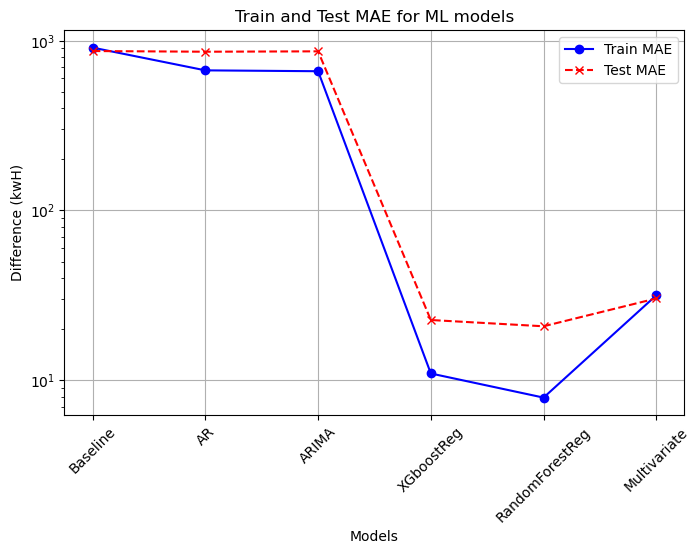

In [12]:
# Values train set
train_values = [908.72, 667.57, 659.78, train_mae_xgbreg, train_mae_rf, train_mae_sarimax]
models = ['Baseline', 'AR', 'ARIMA', 'XGboostReg', 'RandomForestReg', 'Multivariate']

# Values test set
test_values = [867.49, 859.45, 863.91, test_mae_xgbreg, test_mae_rf, test_mae_sarimax]

plt.figure(figsize=(8, 5))

plt.plot(models, train_values, marker='o', linestyle='-', color='b', label='Train MAE')
plt.plot(models, test_values, marker='x', linestyle='--', color='r', label='Test MAE')

plt.xlabel('Models')
plt.ylabel('Difference (kwH)')
plt.title('Train and Test MAE for ML models')
plt.legend()
plt.grid(True)

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.xticks(rotation=45)
plt.show()

***Insights***
- Setting the y-axis to a logarithmic scale for better visualization of all the Mean Absolute Error (MAE), it's noticeable that the Random Forest Regressor model exhibits the lowest MAE, indicating it as the most effective model for predicting electricity consumption in healthcare buildings.

Last step in the analsys is interpretability, here we will analyse the relationships between input features and the predicted outcomes.

[back to TOC](#toc)

<a id='dat03'></a>

# 5. Interpretability

This subject provides insights into how the model arrives at its predictions, offering a deeper understanding of the relationships between input features and the predicted outcomes. In the context of health care buildings electricity consumption prediction, interpretability helps identify the most influential factors impacting electricity usage, aiding stakeholders in making informed decisions regarding energy-efficient practices or retrofit investments. 

We will use two procedures and start with permutation_importance.

In [13]:
from sklearn.inspection import permutation_importance

In [14]:
%%time

# Determine feature importance using the test set
# Repeat the permuation step 100 times per column.
result = permutation_importance(rf_reg, X_test, y_test, n_repeats=100, random_state=0)

CPU times: total: 1min 11s
Wall time: 1min 13s


In [15]:
# Calculate the average importance per feature
importances = result.importances_mean

# Normalize the importances
normalized_importances = importances / importances.sum()


# Put the variable names and their feature importances into a data frame
permute_importances_df = pd.DataFrame({'Variable': X_train.columns,
                               'Importance': importances,
                               'Normalized Importance': normalized_importances})

permute_importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

permute_importances_df

,Variable,Importance,Normalized Importance
0,dew_temperature,2.480452,0.471465
1,air_temperature,1.795206,0.341218
2,month,0.431064,0.081933
3,day,0.255006,0.048470
4,sea_level_pressure,0.250422,0.047598
5,hour,0.023604,0.004487
6,wind_speed,0.013576,0.002580
7,wind_direction,0.011832,0.002249
8,square_feet,0.000000,0.000000


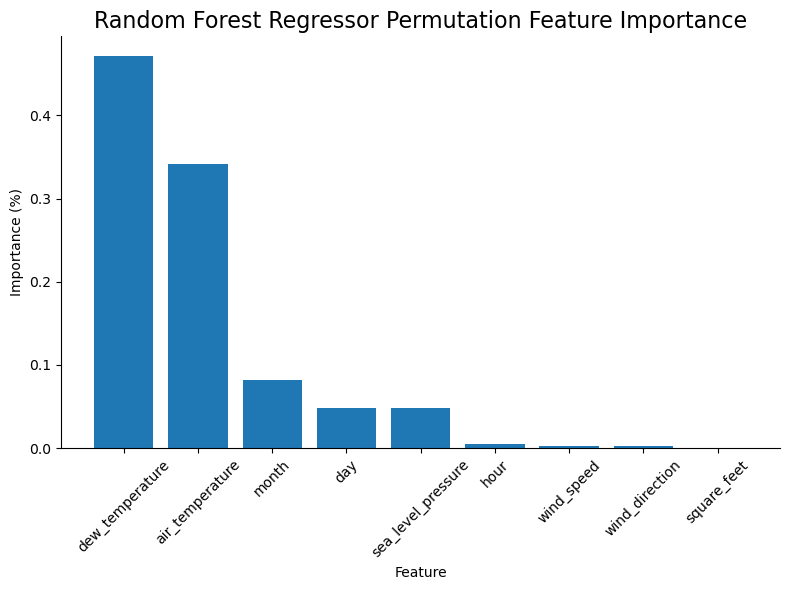

In [16]:
# Plot the importances

figsize=(12,5)

# Permutation Feature Importance
plt.bar(permute_importances_df['Variable'], permute_importances_df['Normalized Importance'])
plt.title('Random Forest Regressor Permutation Feature Importance', fontsize=16)
plt.xlabel('Feature')
plt.ylabel('Importance (%)')
plt.xticks(rotation = 45)
sns.despine()

plt.tight_layout()
plt.show()

***Insights***
- It can be observed how the features related to thermal confort (dew and air temperature), play the most important role.


Let's conclude the capstone project by conducting a similar analysis using Shapley values.

<a id='dat04'></a>

## 5.1. Shapley values
The first step is to fit an 'explainer' model with our fitted model object. The explainer calculates the Shapley values for each feature and each data point in our dataset. 

Let's install shap.

In [17]:
# pip install shap

In [18]:
import shap

In [19]:
%%time 
# Fit tree-specific kernel for SHAP  
explainer = shap.TreeExplainer(rf_reg)

# Obtain SHAP values 
shap_values = explainer.shap_values(X_train)

CPU times: total: 17min 55s
Wall time: 18min 28s


In [20]:
shap_values.shape

(6582, 9)

In [21]:
pd.Series(shap_values[0],X_train.columns).sort_values(ascending=True)

dew_temperature      -26.370086
month                -21.340755
wind_direction        -1.202608
day                   -0.216116
square_feet            0.000000
hour                   0.182004
wind_speed             1.269297
sea_level_pressure     1.798002
air_temperature        3.620903
dtype: float64

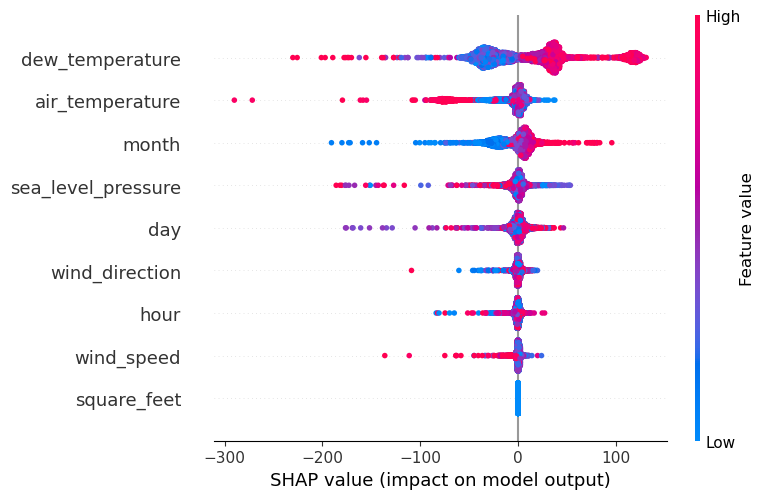

In [22]:
# Global interpretation - summary plot - type = 'dot'
shap.initjs()

shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

***Insights***
- Similar to the previus analysis, it can be observed how the features related to thermal confort (dew and air temperature), play the most important role.
- Dew temperature can influence energy consumption in various ways, primarily in climate control systems. When the dew point temperature is high, it signifies higher humidity levels, impacting how cooling systems operate. Air conditioning units might need to work harder to lower indoor humidity, leading to increased energy usage. Conversely, during colder weather, a lower dew point might affect heating systems differently. In extremely cold conditions, very low dew points might cause dry air, requiring additional energy to maintain comfortable humidity levels indoors. Overall, the dew temperature's impact on energy consumption largely depends on how it interacts with a building's heating, ventilation, and air conditioning (HVAC) systems and their settings.

<a id='concl01'></a>

# 5. Conclusion
The project concludes with the determination that among the models analyzed, the Random Forest Regressor stands out with the lowest Mean Absolute Error (MAE). This finding signifies its efficacy as the most reliable model for predicting electricity consumption in healthcare buildings. Notably, through analysis, it becomes evident that features linked to thermal comfort, such as dew and air temperature, play a pivotal role in influencing energy consumption patterns within these structures. Understanding and prioritizing these comfort-related features are pivotal for accurate predictions and informed decisions towards enhancing energy efficiency in healthcare buildings.